# Trabajo Final Deep Learning - Detección de objetos

## Setup

In [ ]:
import os, shutil, xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.model_selection import train_test_split

## Datos

El entrenamiento de los modelos se realizó de manera local, por lo que es necesario descargar el dataset desde Kaggle (https://www.kaggle.com/datasets/akhatova/pcb-defects).

La descarga manual resultó la opción más sencilla, debido a que otras formas requieren el uso de credenciales o claves de la API de Kaggle. 

### Convertir bounding boxes de VOC a YOLO

El formato de los bounding boxes es VOC, es necesario transformarlo en el formato que YOLO puede emplear.

In [ ]:
# Rutas
BASE = Path("data/pcb-defects/PCB_DATASET")
IM_DIR = BASE/"images"
AN_DIR = BASE/"Annotations"
OUT = BASE/"yolo"
for sub in ["images/train","images/test","labels/train","labels/test"]:
    (OUT/sub).mkdir(parents=True, exist_ok=True)

# Clases de errores en PCBs
classes = ["missing_hole","mouse_bite","open_circuit","short","spur","spurious_copper"]
cls_map = {c:i for i,c in enumerate(classes)}

# Función para convertir xml a labels de YOLO
def convert_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    w = int(root.find("size/width").text)
    h = int(root.find("size/height").text)
    labels = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.lower()
        if cls not in cls_map: continue
        bnd = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [int(bnd.find(tag).text) for tag in ["xmin","ymin","xmax","ymax"]]
        xc = ((xmin+xmax)/2)/w
        yc = ((ymin+ymax)/2)/h
        bw = (xmax-xmin)/w
        bh = (ymax-ymin)/h
        labels.append(f"{cls_map[cls]} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")
    return labels

# Empareja cada imagen con sus anotaciones
all_imgs = []
for cls in classes:
    folder = IM_DIR/cls.capitalize()
    for img in folder.glob("*.jpg"):
        xml = AN_DIR/cls.capitalize()/(img.stem+".xml")
        if xml.exists():
            all_imgs.append((img, xml))

In [2]:
len(all_imgs) # Se extraen 693 pares

693

### División entre train y test

In [ ]:
train, test = train_test_split(all_imgs, test_size=0.2, random_state=18, shuffle=True)

def process(items, split): # 
    for img,xml in items:
        labels = convert_xml(xml) # Convierte xml a formato YOLO
        if not labels: continue
        shutil.copy(img, OUT/f"images/{split}"/img.name) # Copia la imagen a la carpeta correspondiente
        with open(OUT/f"labels/{split}"/(img.stem+".txt"),"w") as f: 
            f.write("\n".join(labels)) # Guarda las etiquetas en un archivo de texto

# Generación de los conjuntos de entrenamiento y prueba
process(train,"train") 
process(test,"test")

print("Done. YOLO dataset at:", OUT)

Done. YOLO dataset at: data\pcb-defects\PCB_DATASET\yolo


### Crear archivo YAML

El archivo YAML es esencial para YOLO, el siguiente bloque genera este archivo que indica las rutas y el nombre de las clases.

In [1]:
import yaml
cfg = {
    "path": "data/pcb-defects/PCB_DATASET/yolo",
    "train": "images/train",
    "val": "images/test",
    "names": {
        0:"missing_hole",1:"mouse_bite",2:"open_circuit",
        3:"short",4:"spur",5:"spurious_copper"
    }
}
out = "data/pcb-defects/PCB_DATASET/yolo/data.yaml"
with open(out,"w") as f: yaml.safe_dump(cfg, f, sort_keys=False)
print("Wrote", out)

Wrote data/pcb-defects/PCB_DATASET/yolo/data.yaml


### EDA

Análisis exploratorio de los datos

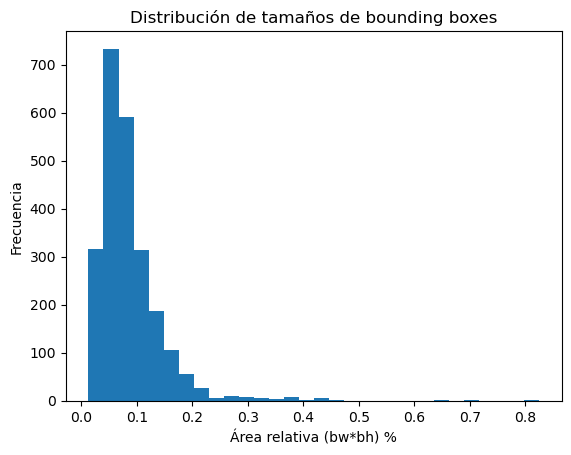

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


BASE = Path("data/pcb-defects/PCB_DATASET/yolo")
IM = BASE/"images/train"
LB = BASE/"labels/train"

# Conteo por clase
counts = {i:0 for i in range(len(classes))}
areas  = []
for lbl in LB.glob("*.txt"):
    for line in lbl.read_text().splitlines():
        cid, xc,yc,bw,bh = map(float,line.split())
        counts[int(cid)] += 1
        areas.append(bw*bh*100)

# Histograma de tamaño relativo de cajas
plt.hist(areas, bins=30)
plt.xlabel("Área relativa (bw*bh) %")
plt.ylabel("Frecuencia")
plt.title("Distribución de tamaños de bounding boxes")
plt.show()

Se observa que el área relativa de los defectos es mínima, alrededor del 0.1%, lo que confirma que este tipo de fallas es difícil de observar a simple vista.

In [6]:
print("Objetos por clase:")
for i,c in enumerate(classes):
    print(f"{c:15s}: {counts[i]}")

Objetos por clase:
missing_hole   : 385
mouse_bite     : 385
open_circuit   : 401
short          : 410
spur           : 337
spurious_copper: 459


Las clases están repartidas casi equitativamente

### Visualizaciones previas

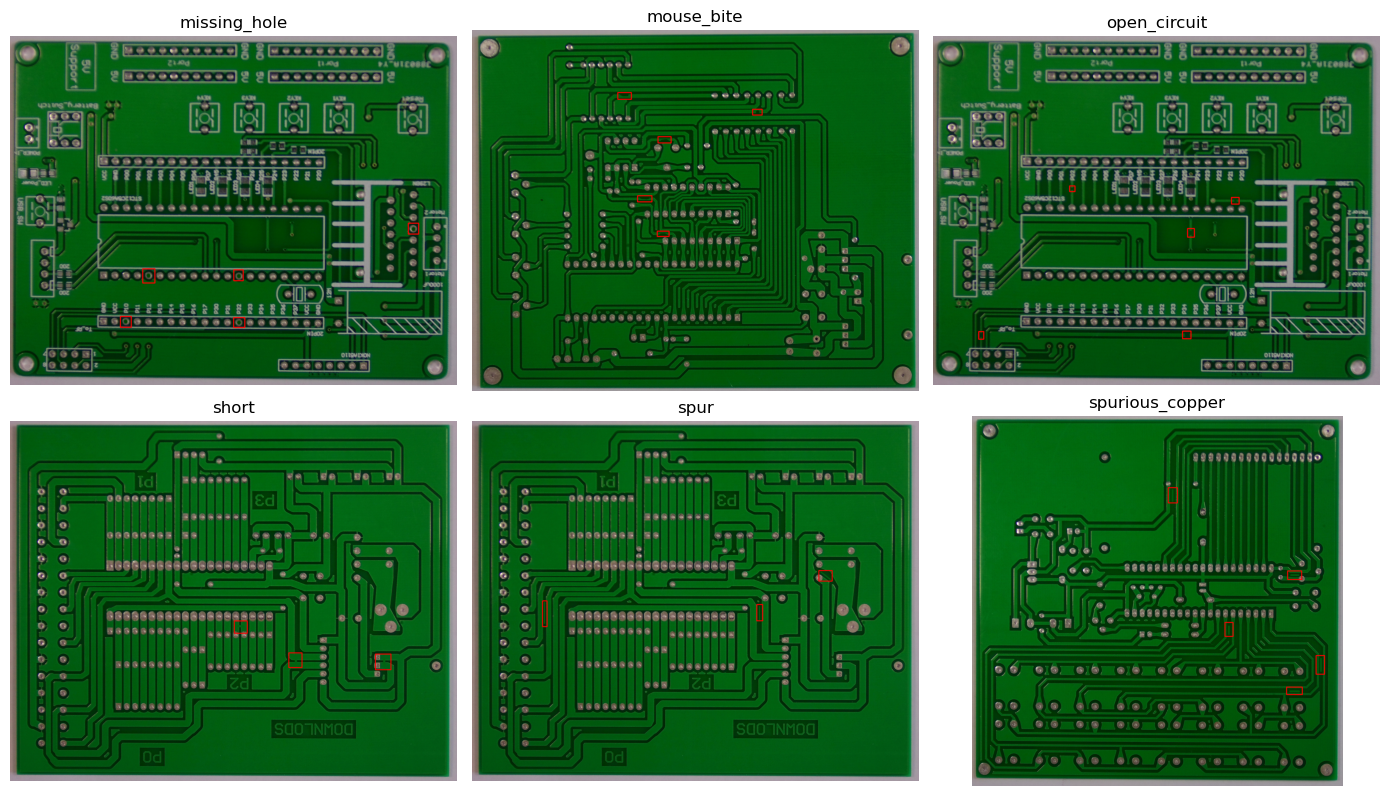

In [7]:
def draw_boxes(img_p, lbl_p):
    img = cv2.imread(str(img_p))
    h, w = img.shape[:2]
    for ln in open(lbl_p):
        cid, xc, yc, bw, bh = map(float, ln.split())
        x1, y1 = int((xc-bw/2)*w), int((yc-bh/2)*h)
        x2, y2 = int((xc+bw/2)*w), int((yc+bh/2)*h)
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),6)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(2,3, figsize=(14,8))
for i, cls in enumerate(classes):
    a = ax.ravel()[i]
    # pick any label file whose name contains the class string
    lbls = list(LB.glob(f"*{cls}*.txt"))
    if not lbls:
        a.axis("off"); a.set_title(f"{cls} (no files)"); continue
    lbl = np.random.choice(lbls)
    img_p = IM/(lbl.stem + ".jpg")
    a.imshow(draw_boxes(img_p, lbl)); a.set_title(cls); a.axis("off")
plt.tight_layout(); plt.show()


Se plotean los ejemplos de defectos para cada clase, como se mencionó anteriormente, estos defectos son bastante pequeños relativos al tamaño de la imagen.

Unique resolutions: 10
3034x1586 : 96 images
3056x2464 : 91 images
2759x2154 : 53 images
2282x2248 : 51 images
2775x2159 : 49 images
2529x2530 : 48 images
2904x1921 : 47 images
2544x2156 : 46 images
2868x2316 : 44 images
2240x2016 : 29 images


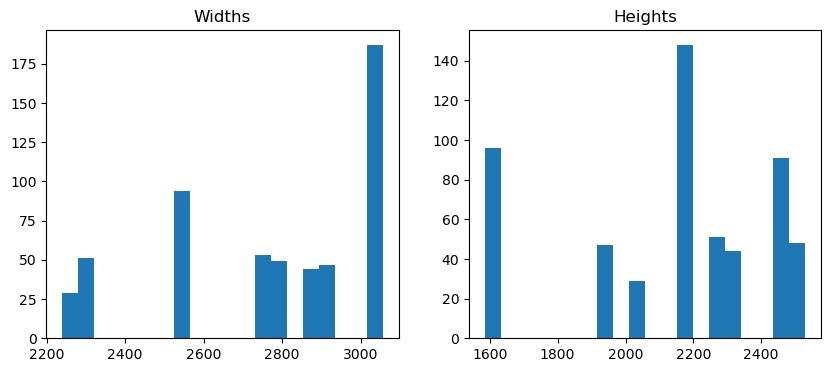

In [8]:
from collections import Counter

sizes = []
for img_p in IM.glob("*.jpg"):
    img = cv2.imread(str(img_p))
    if img is None: continue
    h, w = img.shape[:2]
    sizes.append((w,h))

cnt = Counter(sizes)
print("Unique resolutions:", len(cnt))
for (w,h),n in cnt.most_common(10):
    print(f"{w}x{h} : {n} images")

# Plot distribution of widths and heights
import matplotlib.pyplot as plt
ws, hs = zip(*sizes)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(ws,bins=20); plt.title("Widths")
plt.subplot(1,2,2); plt.hist(hs,bins=20); plt.title("Heights")
plt.show()


Se plotean las resoluciones de las imágenes, las cuales después se transformaran a un tamaño estándar para el entrenamiento.

# Preprocesamiento

Para este trabajo no se ha considerado un preprocesamiento adicional, debido a que YOLO ya realiza el preprocesamiento de las imágenes, así como el data augmentation.

# Entrenamiento

En los siguientes bloques se realiza el entrenamiento del modelo.

In [2]:
from ultralytics import YOLO
import time, glob, os, shutil

In [3]:
DATA = "data/pcb-defects/PCB_DATASET/yolo/data.yaml"
TEST_IMAGES = "data/pcb-defects/PCB_DATASET/yolo/images/test"

def train_and_validate(checkpoint, run_name):
    model = YOLO(checkpoint)
    model.train(
        data=DATA, epochs=20, imgsz=512, batch=8,
        patience=4, seed=18, project="runs/detect", name=run_name, cache='ram'
    )
    metrics = model.val(data=DATA, imgsz=512, verbose=True)
    res = getattr(metrics, "results_dict", {})
    print({
        "model": run_name,
        "mAP@0.5": round(res.get("metrics/mAP50(B)", 0.0), 4),
        "mAP@0.5:0.95": round(res.get("metrics/mAP50-95(B)", 0.0), 4)
    })
    return model, metrics

A continuación se entrenan los 3 modelos de YOLOv8: nano, small y medium

### YOLOv8n

In [5]:
model_nano, metrics_nano = train_and_validate("yolov8n.pt", "v8n")

New https://pypi.org/project/ultralytics/8.3.187 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/pcb-defects/PCB_DATASET/yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v8n, nbs=64, nms=False, opset=None, optimize=False, o

### YOLOv8s

In [12]:
model_small, metrics_small = train_and_validate("yolov8s.pt", "v8s")

Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/pcb-defects/PCB_DATASET/yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=4, perspective=0.0, plots=True, pose=12.0, pretrained=True

### YOLOv8m

In [4]:
model_medium, metrics_medium = train_and_validate("yolov8m.pt", "v8m")

New https://pypi.org/project/ultralytics/8.3.187 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/pcb-defects/PCB_DATASET/yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v8m2, nbs=64, nms=False, opset=None, optimize=False, 

# Evaluación

In [ ]:
import pandas as pd
DATA = "data/pcb-defects/PCB_DATASET/yolo/data.yaml"

models = { # Rutas de los modelos entrenados
    "v8n": "runs/detect/v8n/weights/best.pt",
    "v8s": "runs/detect/v8s/weights/best.pt",
    "v8m": "runs/detect/v8m2/weights/best.pt"
}

results = []
for name, path in models.items():
    model = YOLO(path)
    metrics = model.val(data=DATA, imgsz=512, verbose=False)
    rd = getattr(metrics, "results_dict", {})
    results.append({
        "Model": name,
        "mAP@0.5": rd.get("metrics/mAP50(B)", 0.0),
        "mAP@[.5:.95]": rd.get("metrics/mAP50-95(B)", 0.0),
        "Precision": rd.get("metrics/precision(B)", 0.0),
        "Recall": rd.get("metrics/recall(B)", 0.0)
    })

df = pd.DataFrame(results).set_index("Model")

Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1955.5265.0 MB/s, size: 1303.7 KB)
val: Scanning D:\PhawAI-2025\S3-Deep Learning\data\pcb-defects\PCB_DATASET\yolo\labels\test.cache... 139 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 139/139  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.95it/s 9.5s
                   all        139        576      0.733      0.569      0.626      0.284
Speed: 0.6ms preprocess, 30.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2072.5389.0 MB/s, size: 1460.7 KB)
val: Scanning D:\PhawAI-2025

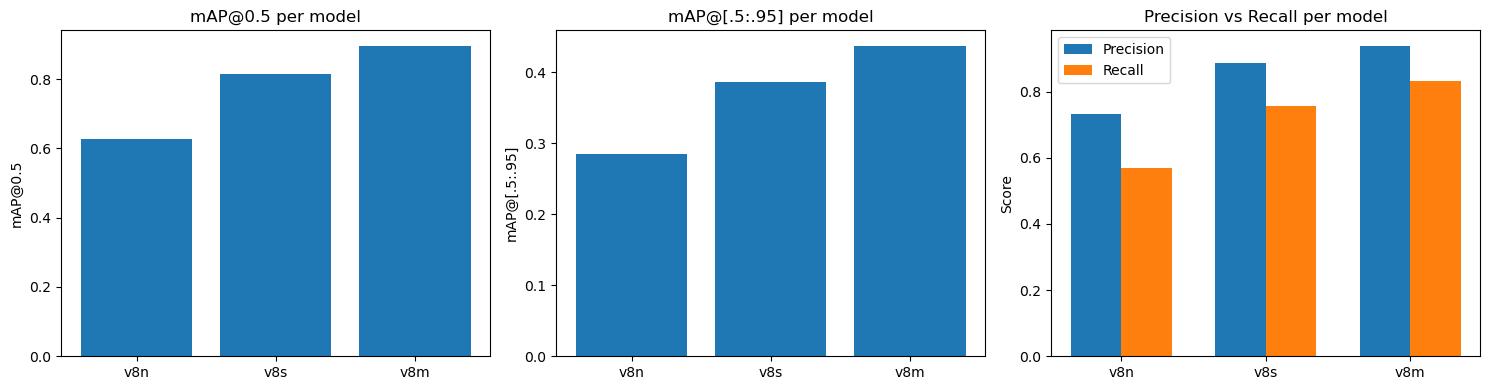

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# mAP@0.5
axes[0].bar(df.index, df["mAP@0.5"])
axes[0].set_title("mAP@0.5 per model")
axes[0].set_ylabel("mAP@0.5")

# mAP@[.5:.95]
axes[1].bar(df.index, df["mAP@[.5:.95]"])
axes[1].set_title("mAP@[.5:.95] per model")
axes[1].set_ylabel("mAP@[.5:.95]")

# Precision vs Recall
x = range(len(df))
width = 0.35
axes[2].bar([i - width/2 for i in x], df["Precision"], width=width, label="Precision")
axes[2].bar([i + width/2 for i in x], df["Recall"], width=width, label="Recall")
axes[2].set_xticks(x)
axes[2].set_xticklabels(df.index)
axes[2].set_title("Precision vs Recall per model")
axes[2].set_ylabel("Score")
axes[2].legend()

plt.tight_layout()
plt.show()


# Inferencia de ejemplo

In [25]:
%matplotlib inline
import glob, os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
DATA_YOLO = "data/pcb-defects/PCB_DATASET/yolo"
TEST_IM_DIR = os.path.join(DATA_YOLO, "images/test")

models = [
    ("v8n", "runs/detect/v8n/weights/best.pt"),
    ("v8s", "runs/detect/v8s/weights/best.pt"),
    ("v8m", "runs/detect/v8m2/weights/best.pt"),
]

# mismas 3 imágenes aleatorias para todos
all_test_imgs = glob.glob(os.path.join(TEST_IM_DIR, "*.jpg"))
assert len(all_test_imgs) >= 3, "Need at least 3 test images."
test_imgs = np.random.choice(all_test_imgs, size=3, replace=False)


# Carga modelos 
loaded = []
for m in models:
    name, ckpt = m[:2]
    loaded.append((name, YOLO(ckpt)))

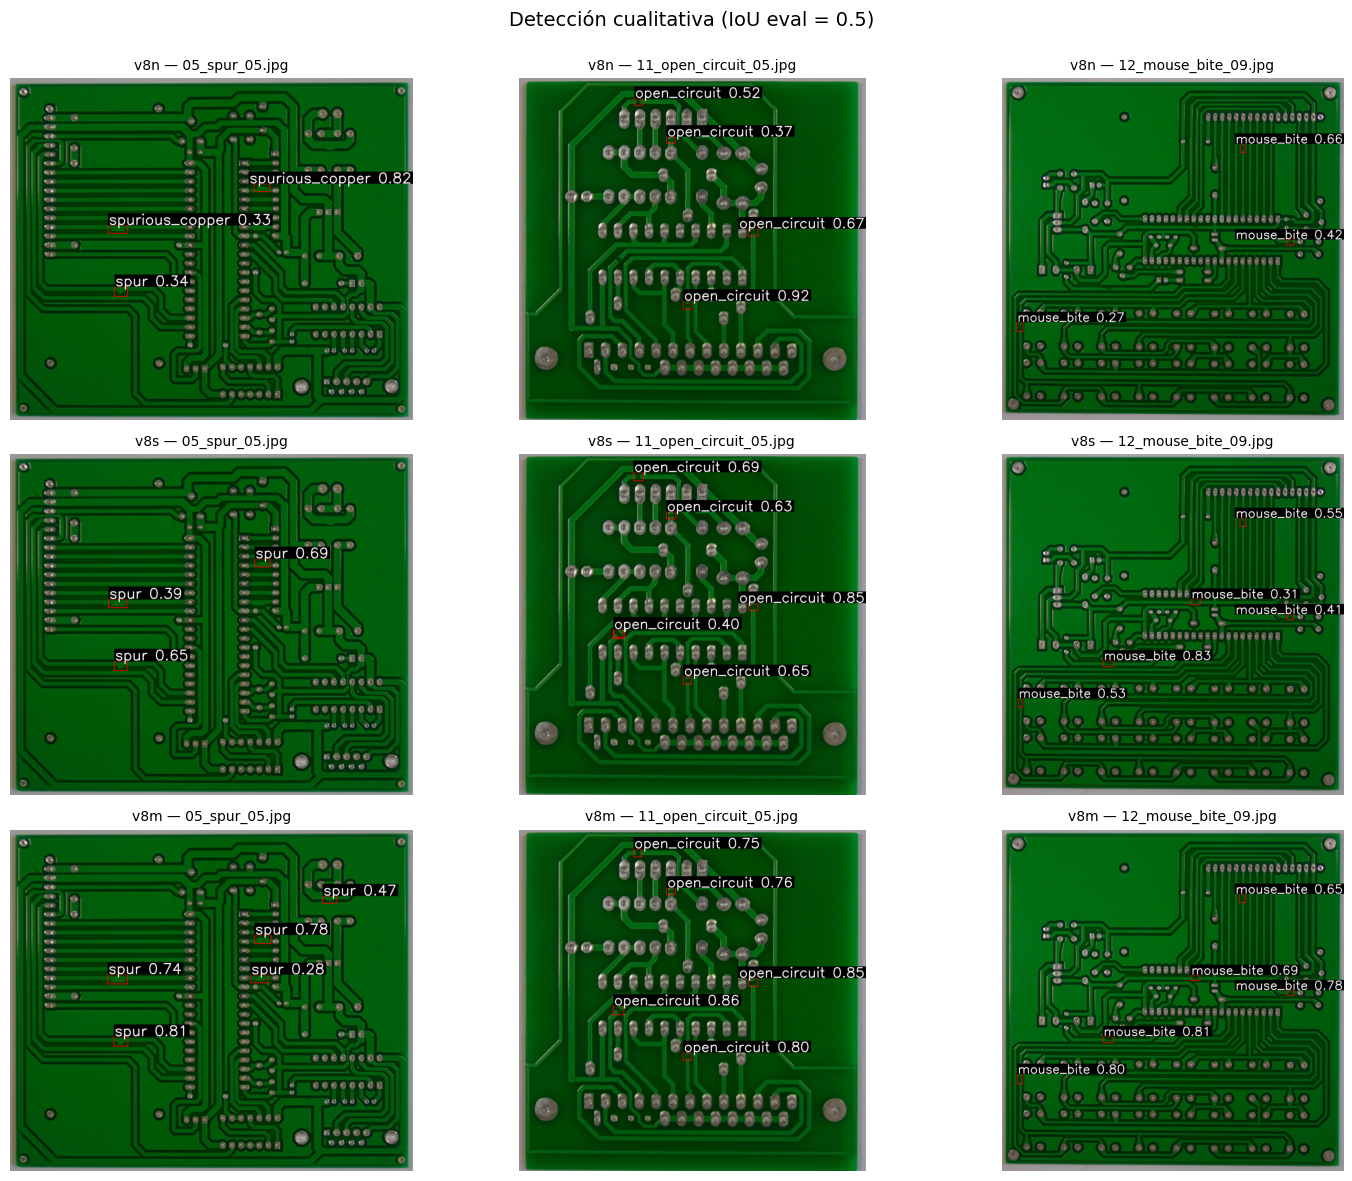

In [26]:
def draw_preds_bgr(img_bgr, result, names):
    h, w = img_bgr.shape[:2]
    for b in result.boxes:
        x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
        cls_id = int(b.cls[0].item())
        conf = float(b.conf[0].item())
        label = f"{names[cls_id]} {conf:.2f}"

        # draw bounding box
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 0, 255), 4)

        # big text
        font_scale = 3.0
        thickness = 5
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # anchor point, clamped inside image
        x_text = max(0, min(x1, w - tw - 10))
        y_text = max(th + 10, min(y1, h - 10))

        # black background box
        cv2.rectangle(img_bgr, (x_text, y_text - th - 10), (x_text + tw + 10, y_text), (0, 0, 0), -1)
        cv2.putText(img_bgr, label, (x_text + 5, y_text - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255),
                    thickness, cv2.LINE_AA)
    return img_bgr


# 3x3: filas=modelos, columnas=imágenes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Detección cualitativa (IoU eval = 0.5)", fontsize=14)

for r, (model_name, model) in enumerate(loaded):
    # warmup
    _ = model.predict(source=test_imgs[0], imgsz=512, conf=0.25, verbose=False)
    for c, img_path in enumerate(test_imgs):
        res = model.predict(source=img_path, imgsz=512, conf=0.25, verbose=False)[0]
        img_bgr = cv2.imread(img_path)
        vis = cv2.cvtColor(draw_preds_bgr(img_bgr.copy(), res, model.names), cv2.COLOR_BGR2RGB)
        ax = axes[r, c]
        ax.imshow(vis)
        ax.set_title(f"{model_name} — {os.path.basename(img_path)}", fontsize=10)
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Guardado de resultados

In [3]:
import pandas as pd
from ultralytics import YOLO

DATA = "data/pcb-defects/PCB_DATASET/yolo/data.yaml"

runs = {
    "v8n":  "runs/detect/v8n",
    "v8s":  "runs/detect/v8s",
    "v8m":  "runs/detect/v8m2",
}

def train_metrics(run_dir):
    df = pd.read_csv(f"{run_dir}/results.csv")
    last = df.iloc[-1]
    return {
        "Precision_train":   float(last["metrics/precision(B)"]),
        "Recall_train":      float(last["metrics/recall(B)"]),
        "mAP@0.5_train":     float(last["metrics/mAP50(B)"]),
        "mAP@[.5:.95]_train":float(last["metrics/mAP50-95(B)"]),
    }

def test_metrics(run_dir):
    model = YOLO(f"{run_dir}/weights/best.pt")
    m = model.val(data=DATA, imgsz=512, verbose=False).results_dict
    return {
        "Precision_test":    float(m["metrics/precision(B)"]),
        "Recall_test":       float(m["metrics/recall(B)"]),
        "mAP@0.5_test":      float(m["metrics/mAP50(B)"]),
        "mAP@[.5:.95]_test": float(m["metrics/mAP50-95(B)"]),
    }

rows = []
for name, rdir in runs.items():
    row = {"Model": name}
    row.update(train_metrics(rdir))
    row.update(test_metrics(rdir))
    rows.append(row)

tbl = pd.DataFrame(rows).set_index("Model")
print(tbl.round(4))

# Optional exports for report
tbl.round(4).to_csv("train_test_metrics.csv")


Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1854.0184.5 MB/s, size: 1254.6 KB)
val: Scanning D:\PhawAI-2025\S3-Deep Learning\data\pcb-defects\PCB_DATASET\yolo\labels\test.cache... 139 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 139/139  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.88it/s 10.2s
                   all        139        576      0.733      0.569      0.626      0.284
Speed: 0.7ms preprocess, 33.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val4
Ultralytics 8.3.186  Python-3.10.18 torch-2.5.1 CPU (AMD Ryzen 5 5500)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1944.7240.9 MB/s, size: 1226.4 KB)
val: Scanning D:\PhawAI-20